# Aspect Based sentiment anlaysis with topic modeling

## Importation des bibliothèques et des données.

In [1]:
import os
os.chdir("..")

In [2]:
from nltk.corpus import stopwords
import re
import seaborn as sns
from time import time
from Preprocessors.ReviewPreprocessor import ReviewPreprocessor
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")

import pyLDAvis.gensim_models
import pyLDAvis
pyLDAvis.enable_notebook()

from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

from IPython.display import HTML

e:\pychcarmprojects\s4\servqc_ml\venv\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [3]:
datasets = ['data/3 datasets/reviews_TripAdvisor_2022_5_20_11_27_56_ 10pages_10hotels.csv',
            'data/3 datasets/reviews_Booking_2022_5_20_11_9_54_10links_10_pages.csv',
            'data/3 datasets/reviews_Agoda_2022_5_20_10_58_5_10pages_10_links.csv',
            'data/3 datasets/reviews_Agoda_2022_5_21_11_32_11_London_5pages_5links.csv',
            'data/3 datasets/reviews_TripAdvisor_2022_5_21_11_51_26_london_5pages_5links.csv']
dataset = pd.DataFrame(columns = ['listing_name', 'listing_score', 'username', 'review_score', 'review_title', 'review'])
for d in datasets :
    dataset = pd.concat([dataset, pd.read_csv(d)],ignore_index = True)

In [4]:
dataset

,listing_name,listing_score,username,review_score,review_title,review
0,Hotel de la Paix Tour Eiffel,4.5,Casey V,5.0,"Charming, clean, and GREAT service!",I was at this hotel last week in a single room...
1,Hotel de la Paix Tour Eiffel,4.5,AHLife93,5.0,Best hotel,We enjoyed our stay. The staff was friendly an...
2,Hotel de la Paix Tour Eiffel,4.5,Katie Anne,5.0,Great Hotel!,I had a fantastic stay at Hotel de la Paix! I ...
3,Hotel de la Paix Tour Eiffel,4.5,pollybrown67,5.0,Paris April 2022,"Upon our arrival to the hotel, we received a w..."
4,Hotel de la Paix Tour Eiffel,4.5,Vianey G,5.0,Great hotel,Great customer services all Front Desk agents ...
...,...,...,...,...,...,...
4291,The Gate,5.0,Laura K,2.0,Not suitable for a long-term stay,This hotel would be okay for a short city trip...
4292,The Gate,5.0,91nk2012,2.0,Confused with all the 5 star reviews. Very poo...,Stayed at this hotel during valentines weekend...
4293,The Gate,5.0,Ryan G,1.0,"Stay away from awful, racist place","Avoid this awful, cold space where they put yo..."
4294,The Gate,5.0,Thomas,1.0,Party Hotel,This hotel is full of young people having part...


## Prétraitement des données

In [5]:
review_preprocessor = ReviewPreprocessor(dataset['review'], nlp)
old = time()
dataset['cleaned_data'] = review_preprocessor.remove_tags()
dataset['cleaned_data'] = review_preprocessor.lowercase_transformation()
dataset['cleaned_data'] = review_preprocessor.pararel_spelling_correction()
dataset['cleaned_data'] = review_preprocessor.remove_objective_sentences()
dataset = dataset[dataset['cleaned_data'] != ""]
print(f"cleaning took {time() - old}")

4296it [01:37, 44.00it/s]

cleaning took 353.67518639564514


In [6]:
_stopwords = stopwords.words('english')
_stopwords.extend(['nt'])

In [7]:
tokenized_sentences = []
text_sentences = []
for i, _review in dataset.iterrows():
    review = nlp(_review['cleaned_data'])            
    for sentence in review.sents:
        _sent = []
        text_sentences.append(sentence.text)
        for token in sentence:
            # remove ponctuation
            token = re.sub(r'[^\w\s]', '', token.text)
            # add tokent to _sent when it is not a stopword and not short (less than two chars)
            if len(token) >= 2 and token not in _stopwords:
                _sent.append(token)
        tokenized_sentences.append(_sent)

In [8]:
id2word = Dictionary(tokenized_sentences)
corpus = [id2word.doc2bow(text) for text in tokenized_sentences]

## Application de modèle LDA

In [9]:
lda_model = LdaMulticore(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=6,
                                   random_state=42,
                                   chunksize=15,
                                   passes=10,
                                   iterations=5,
                                   alpha=0.02,
                                   eta=0.3,
                                  workers = 4)

In [10]:
CoherenceModel(model=lda_model,
                       texts=tokenized_sentences,
                       dictionary=id2word,
                       coherence='c_v').get_coherence()

0.4251560062757933

**Affichage des topics**

In [11]:
lda_model.print_topics()

[(0,
  '0.042*"room" + 0.017*"bar" + 0.015*"check" + 0.011*"free" + 0.011*"one" + 0.010*"water" + 0.009*"even" + 0.009*"hot" + 0.009*"could" + 0.009*"coffee"'),
 (1,
  '0.043*"stay" + 0.042*"hotel" + 0.040*"would" + 0.014*"recommend" + 0.013*"definitely" + 0.011*"first" + 0.010*"place" + 0.010*"like" + 0.009*"highly" + 0.009*"bit"'),
 (2,
  '0.086*"staff" + 0.047*"breakfast" + 0.038*"friendly" + 0.036*"good" + 0.029*"service" + 0.028*"helpful" + 0.024*"great" + 0.020*"nice" + 0.019*"hotel" + 0.016*"food"'),
 (3,
  '0.084*"room" + 0.053*"clean" + 0.036*"rooms" + 0.029*"comfortable" + 0.029*"small" + 0.027*"bed" + 0.025*"hotel" + 0.024*"well" + 0.018*"bathroom" + 0.016*"lovely"'),
 (4,
  '0.059*"location" + 0.034*"hotel" + 0.030*"great" + 0.028*"london" + 0.018*"perfect" + 0.017*"good" + 0.016*"walk" + 0.012*"station" + 0.011*"easy" + 0.011*"close"'),
 (5,
  '0.025*"us" + 0.020*"time" + 0.017*"night" + 0.016*"stayed" + 0.014*"could" + 0.013*"made" + 0.011*"better" + 0.011*"amazing" + 0.0

nous pouvons déduire les topic suivantes: **food, room, staff, room, location, hotel**

In [12]:
topics = ['food', 'room', 'staff', 'room', 'location', 'hotel']

## Analyse des sentiments

In [13]:
from textblob import TextBlob

In [14]:
counts = [0,0,0]
aspects_counts = {'food': [0,0,0], 'room': [0,0,0], 'staff': [0,0,0], 'location': [0,0,0], 'hotel': [0,0,0]}
for i,sentence in enumerate(text_sentences):
    result = lda_model[id2word.doc2bow(sentence.split())]
    polarity = TextBlob(sentence).polarity
    
    max_topic = max(result,key=lambda item:item[1])
    topic = topics[max(result,key=lambda item:item[1])[0]]
    
    if polarity >= 0.2:
        sentiment = "positive"
        counts[0]+=1
        aspects_counts[topic][0] += 1
    elif polarity <=-0.2:
        sentiment = "negative"
        counts[1]+=1
        aspects_counts[topic][1] += 1
    else:
        sentiment = "netural"
        counts[2]+=1
        aspects_counts[topic][2] += 1
        
    if i < 50:
        print(sentence, "////", sentiment, topic, max_topic)        
        print("====================================")

 of course, the hotel is small, and my room was very small... but who is staying inside the room while on a trip to paris!?! //// negative room (3, 0.56843805)
the bed was comfortable, shower had hot water and good water pressure, breakfast was simple but delicious, and overall -everything was clean, and very nice. //// positive staff (2, 0.42526564)
but the best part of my experience by far was the charming and kind front desk host named died. //// positive staff (2, 0.5514163)
from the moment i arrived until he arranged my taxi to the airport, he was extremely helpful. //// netural hotel (5, 0.9804665)
he called me by name, ensured everything was to my liking, smiled and chatted many times, and made my short stay feel personal and wonderful. //// positive hotel (5, 0.5020222)
i would definitely stay at this hotel again! //// netural room (1, 0.9757281)
 we enjoyed our stay. //// positive location (4, 0.91071266)
the staff was friendly and helpful in helping us navigate paris. //// po

In [15]:
TextBlob("it's a great centrally located hotel and i would stay here again!").polarity

0.4

In [16]:
import seaborn as sns

In [17]:
counts

[10733, 1601, 3927]

In [18]:
aspects_counts

{'food': [1738, 388, 893],
 'room': [2984, 732, 1594],
 'staff': [2797, 167, 338],
 'location': [2448, 73, 517],
 'hotel': [766, 241, 585]}

In [31]:
import matplotlib.pyplot as plt

([<matplotlib.patches.Wedge at 0x2367157b910>,
 [Text(-0.5300668375171229, 0.9638615812265765, 'positive'),
  Text(-0.27841800638551084, -1.0641820397471091, 'negative'),
  Text(0.7983127558099836, -0.7567672983890553, 'neutre')])

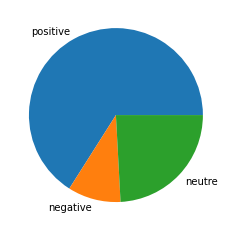

In [34]:
plt.pie(x = counts, labels = ["positive", "negative", "neutre"])

In [20]:
import pandas as pd

In [21]:
aspects_counts

{'food': [1738, 388, 893],
 'room': [2984, 732, 1594],
 'staff': [2797, 167, 338],
 'location': [2448, 73, 517],
 'hotel': [766, 241, 585]}

In [22]:
agregated_data = pd.DataFrame(aspects_counts).transpose()

In [23]:
agregated_data = agregated_data.reset_index()

In [24]:
agregated_data.columns = ['aspect', 'positive', 'negative', 'netural']

In [25]:
agregated_data

,aspect,positive,negative,netural
0,food,1738,388,893
1,room,2984,732,1594
2,staff,2797,167,338
3,location,2448,73,517
4,hotel,766,241,585


<AxesSubplot:xlabel='aspect', ylabel='positive'>

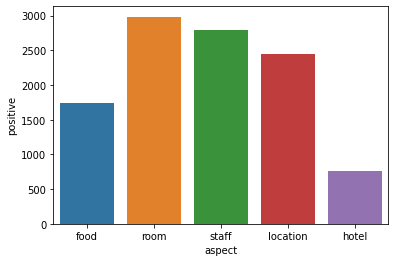

In [26]:
sns.barplot(x = 'aspect', y = 'positive', data = agregated_data)

<AxesSubplot:xlabel='aspect', ylabel='negative'>

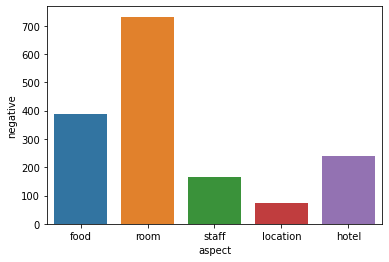

In [27]:
sns.barplot(x = 'aspect', y = 'negative', data = agregated_data)

<AxesSubplot:xlabel='aspect', ylabel='netural'>

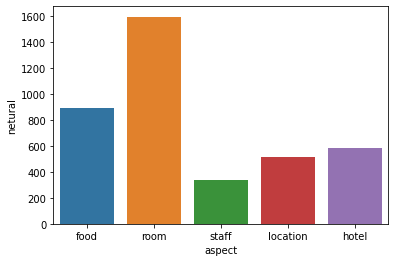

In [28]:
sns.barplot(x = 'aspect', y = 'netural', data = agregated_data)